In [1]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
from sklearn.cluster import KMeans  # k-means 군집분석
from sklearn.metrics import silhouette_score  # 군집분석 평가를 위한 silhouette 값 계산
from yellowbrick.cluster.elbow import kelbow_visualizer
from yellowbrick.cluster import silhouette_visualizer
from collections import Counter
import datetime as dt
import math
from sklearn import metrics
import pandas_profiling as pp
from sklearn.metrics.pairwise import cosine_similarity
#from sklearn import preprocessing #로그 변환을 위한 라이브러리 

/Users/seongyoon/programming/program/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
import platform
path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...')
rc('axes', unicode_minus=False)

# 5. K-means Clustering을 위한 Feature Selection

In [3]:
ft = pd.read_excel('feature.xlsx')

In [4]:
#ft 중에서 오직 연속형 변수만이 군집화에 사용됨.

ft2 = ft[['clnt_id','연령대', '총구매액', '구매건수', '구매상품평균단가',
         '내점일수', '구매주기', '휴먼기간', '최빈구매요일집중도','주구매시간',
          '상품군재구매율','장바구니추가건수','세션_페이지']]

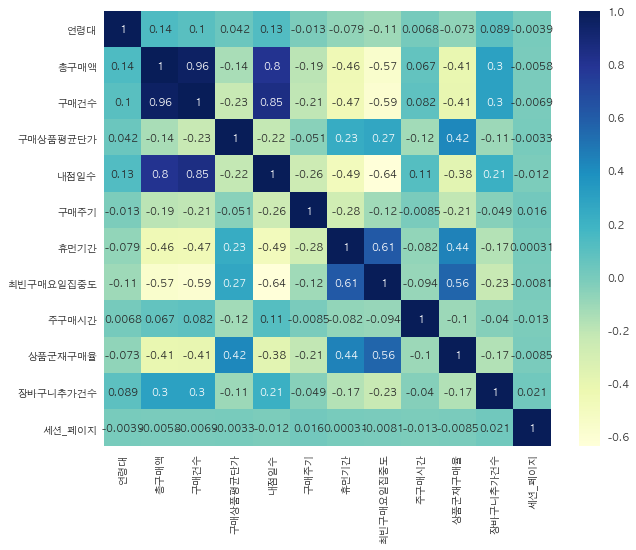

In [5]:
# 상관계수(-1 ~ +1)를 통해 feature 간의 유사성을 파악

plt.figure(figsize=(10,8))
sns.heatmap(ft2.iloc[:,1:].corr(), annot=True, cmap="YlGnBu")
plt.show()

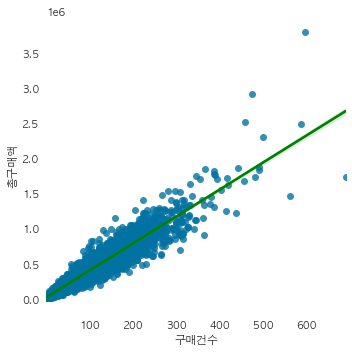

In [6]:
sns.lmplot(x='구매건수', y='총구매액', data=ft2, 
           line_kws={'color':"green"}, scatter_kws={'edgecolor':"white"})
plt.show()

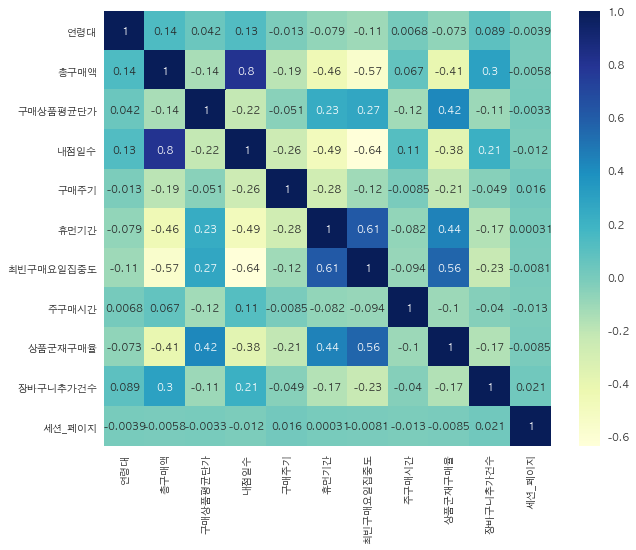

In [7]:
#상관관계가 너무 높은 변수('구매건수') 제거

final_ft = ft2.drop(columns=['구매건수'])
plt.figure(figsize=(10,8))
sns.heatmap(final_ft.iloc[:,1:].corr(), annot=True, cmap="YlGnBu")
plt.show()

# 6. K-mean Clustering 군집 개수 선정.

In [8]:
#로그변환후 정규화실행
X = final_ft.iloc[:,1:].apply(lambda x: np.log(x+1))
X = X.iloc[:,1:].apply(lambda x: (x - x.mean()) / x.std(), axis=1) 

In [9]:
wss = []
sis = []
for k in range(2,10):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X)
    wss = np.append(wss, kmeans.inertia_)
    sis = np.append(sis, silhouette_score(X, kmeans.labels_))

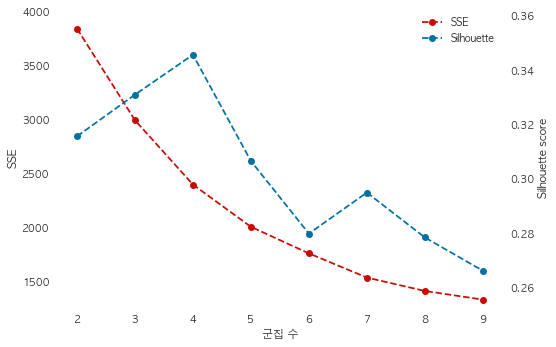

In [10]:
# 군집 수에 따른 SSE와 Silhouette score 시각화
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

line1 = ax1.plot(np.arange(2,10), wss, 'ro--', label='SSE')
line2 = ax2.plot(np.arange(2,10), sis, 'bo--', label='Silhouette') 

ax1.set_ylim(wss.min()*0.95, wss.max()*1.05)
ax2.set_ylim(sis.min()*0.95, sis.max()*1.05) #값의 최대치를 정함. 

ax1.set_xlabel('군집 수')
ax1.set_ylabel('SSE')
ax2.set_ylabel('Silhouette score')

lines = line1 + line2
labels = [l.get_label() for l in lines]

plt.legend(lines, labels)
plt.show()

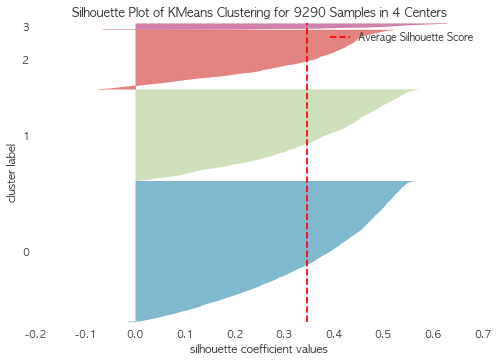

/Users/seongyoon/programming/program/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fbfa28f8810>,
                     colors='yellowbrick', is_fitted='auto', model=None)

In [11]:
silhouette_visualizer(KMeans(4, random_state=0), X, colors='yellowbrick')

# 7. K-mean Clustering 실행.

In [12]:
# sns 설정이 바뀌었기 때문에 원래로 되돌린다.
sns.reset_defaults()
%matplotlib inline

# Yellowbrick은 영문 폰트를 사용하여 시각화를 하기 떄문에 다시 한글 폰트로 변경해야 한다.
path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...')
rc('axes', unicode_minus=False)

In [13]:
best_k = 4
kmeans = KMeans(n_clusters=best_k, random_state=0)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [14]:
final_ft['세그먼트'] = kmeans.labels_
final_ft

,clnt_id,연령대,총구매액,구매상품평균단가,내점일수,구매주기,휴먼기간,최빈구매요일집중도,주구매시간,상품군재구매율,장바구니추가건수,세션_페이지,세그먼트
0,21922,50,79980,6006.92,5,16,10,0.38,21,0.31,44,3.75,0
1,21279,40,851652,3541.05,19,4,5,0.44,10,0.17,470,2.14,0
2,39423,50,468662,3194.41,18,5,0,0.24,15,0.17,441,1.72,0
3,18362,40,502020,4158.25,20,4,0,0.30,10,0.14,129,4.22,0
4,48969,40,330510,3046.08,10,8,3,0.38,10,0.24,163,1.05,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9285,56024,40,13800,13800.00,1,0,12,1.00,1,1.00,0,1.66,2
9286,30052,40,10900,10900.00,1,0,74,1.00,12,1.00,0,4.66,2
9287,69892,40,13000,13000.00,1,0,9,1.00,8,1.00,0,1.23,2
9288,9252,30,11040,11040.00,1,0,9,1.00,10,1.00,0,1.58,2


In [15]:
seg_info = final_ft.drop('clnt_id', axis = 1)

In [16]:
#각 세그먼트별로의 변수의 평균값을 확인
seg_info = seg_info.groupby('세그먼트').apply(lambda x: round(x.mean(),2))
seg_info

,연령대,총구매액,구매상품평균단가,내점일수,구매주기,휴먼기간,최빈구매요일집중도,주구매시간,상품군재구매율,장바구니추가건수,세션_페이지,세그먼트
세그먼트,,,,,,,,,,,,
0,37.87,309333.75,3774.85,11.33,8.71,10.92,0.44,15.20,0.25,82.39,2.95,0.0
1,36.68,235568.12,4017.31,8.96,10.49,14.15,0.51,16.12,0.28,1.11,3.31,1.0
2,35.50,31059.79,5196.58,1.27,0.94,52.44,0.94,14.77,0.59,10.28,3.21,2.0
3,37.43,248511.47,4107.78,9.48,7.28,19.27,0.54,15.56,0.32,50.12,64454.34,3.0


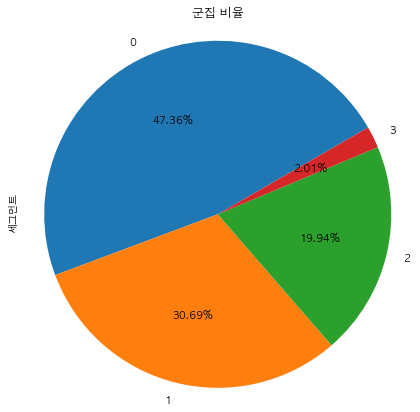

In [17]:
#각 세그먼트에 속한 고객들를 pie chart로 나타냄

plt.figure(figsize=(6,6))
final_ft.세그먼트.value_counts().plot.pie(autopct='%.2f%%', figsize=(7,7), 
                                      startangle=30, legend=False)
plt.title("군집 비율")
plt.axis('equal')
plt.show()

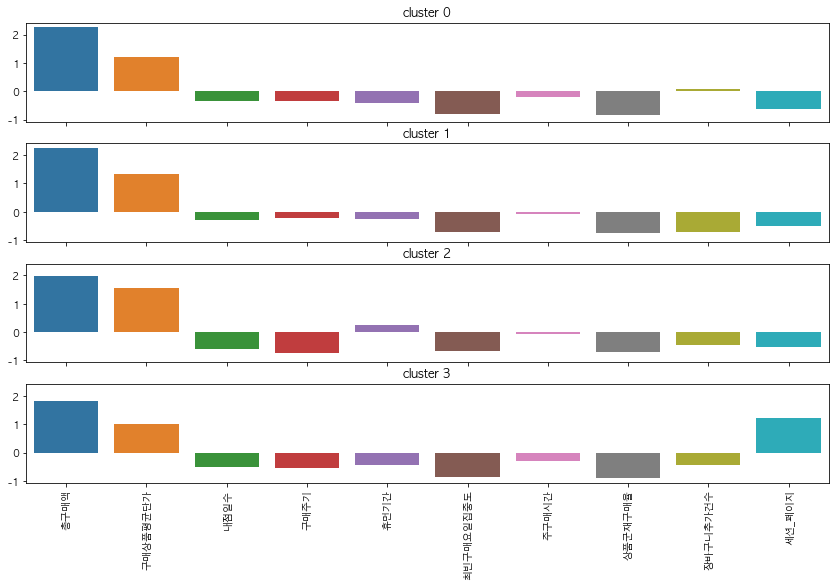

In [18]:
fig, ax = plt.subplots(best_k, 1, figsize=(12,7), sharex=True, sharey=True)
ax = ax.ravel()
plt.tight_layout()

for i in range(kmeans.n_clusters):
    ax[i].set_title('cluster %d' % i)
#    ax[i].bar(np.arange(X.columns.size), kmeans.cluster_centers_[i])
    sns.barplot(np.arange(X.columns.size), kmeans.cluster_centers_[i], ax=ax[i])
    ax[i].set_xticks(np.arange(X.columns.size))
    ax[i].set_xticklabels(X.columns, rotation=90)

In [19]:
cs_seg = pd.read_excel('final_ft.xlsx')
cs_seg = cs_seg[['clnt_id','세그먼트']]
cs_tr = pd.read_csv('cs_tr.csv')
data = pd.merge(cs_tr,cs_seg, on = 'clnt_id')

In [20]:
a = pd.pivot_table(data,values = 'clnt_id', index = 'clac_nm1', columns = '세그먼트',
              aggfunc= np.size)
a

세그먼트,0,1,2,3
clac_nm1,,,,
Automotive Products,243.0,377.0,24.0,12.0
Baby Foods,787.0,1074.0,23.0,38.0
Ball Game / Field Sports,93.0,76.0,12.0,3.0
Bedding / Handicraft,166.0,211.0,13.0,10.0
Beverages,22776.0,9755.0,761.0,770.0
Birth Supplies / Baby Products,740.0,706.0,46.0,25.0
Books / Records / Instruments,109.0,134.0,18.0,5.0
Canned / Jarred Foods,5077.0,1620.0,247.0,149.0
Cell Phones / Accessories,20.0,42.0,7.0,5.0


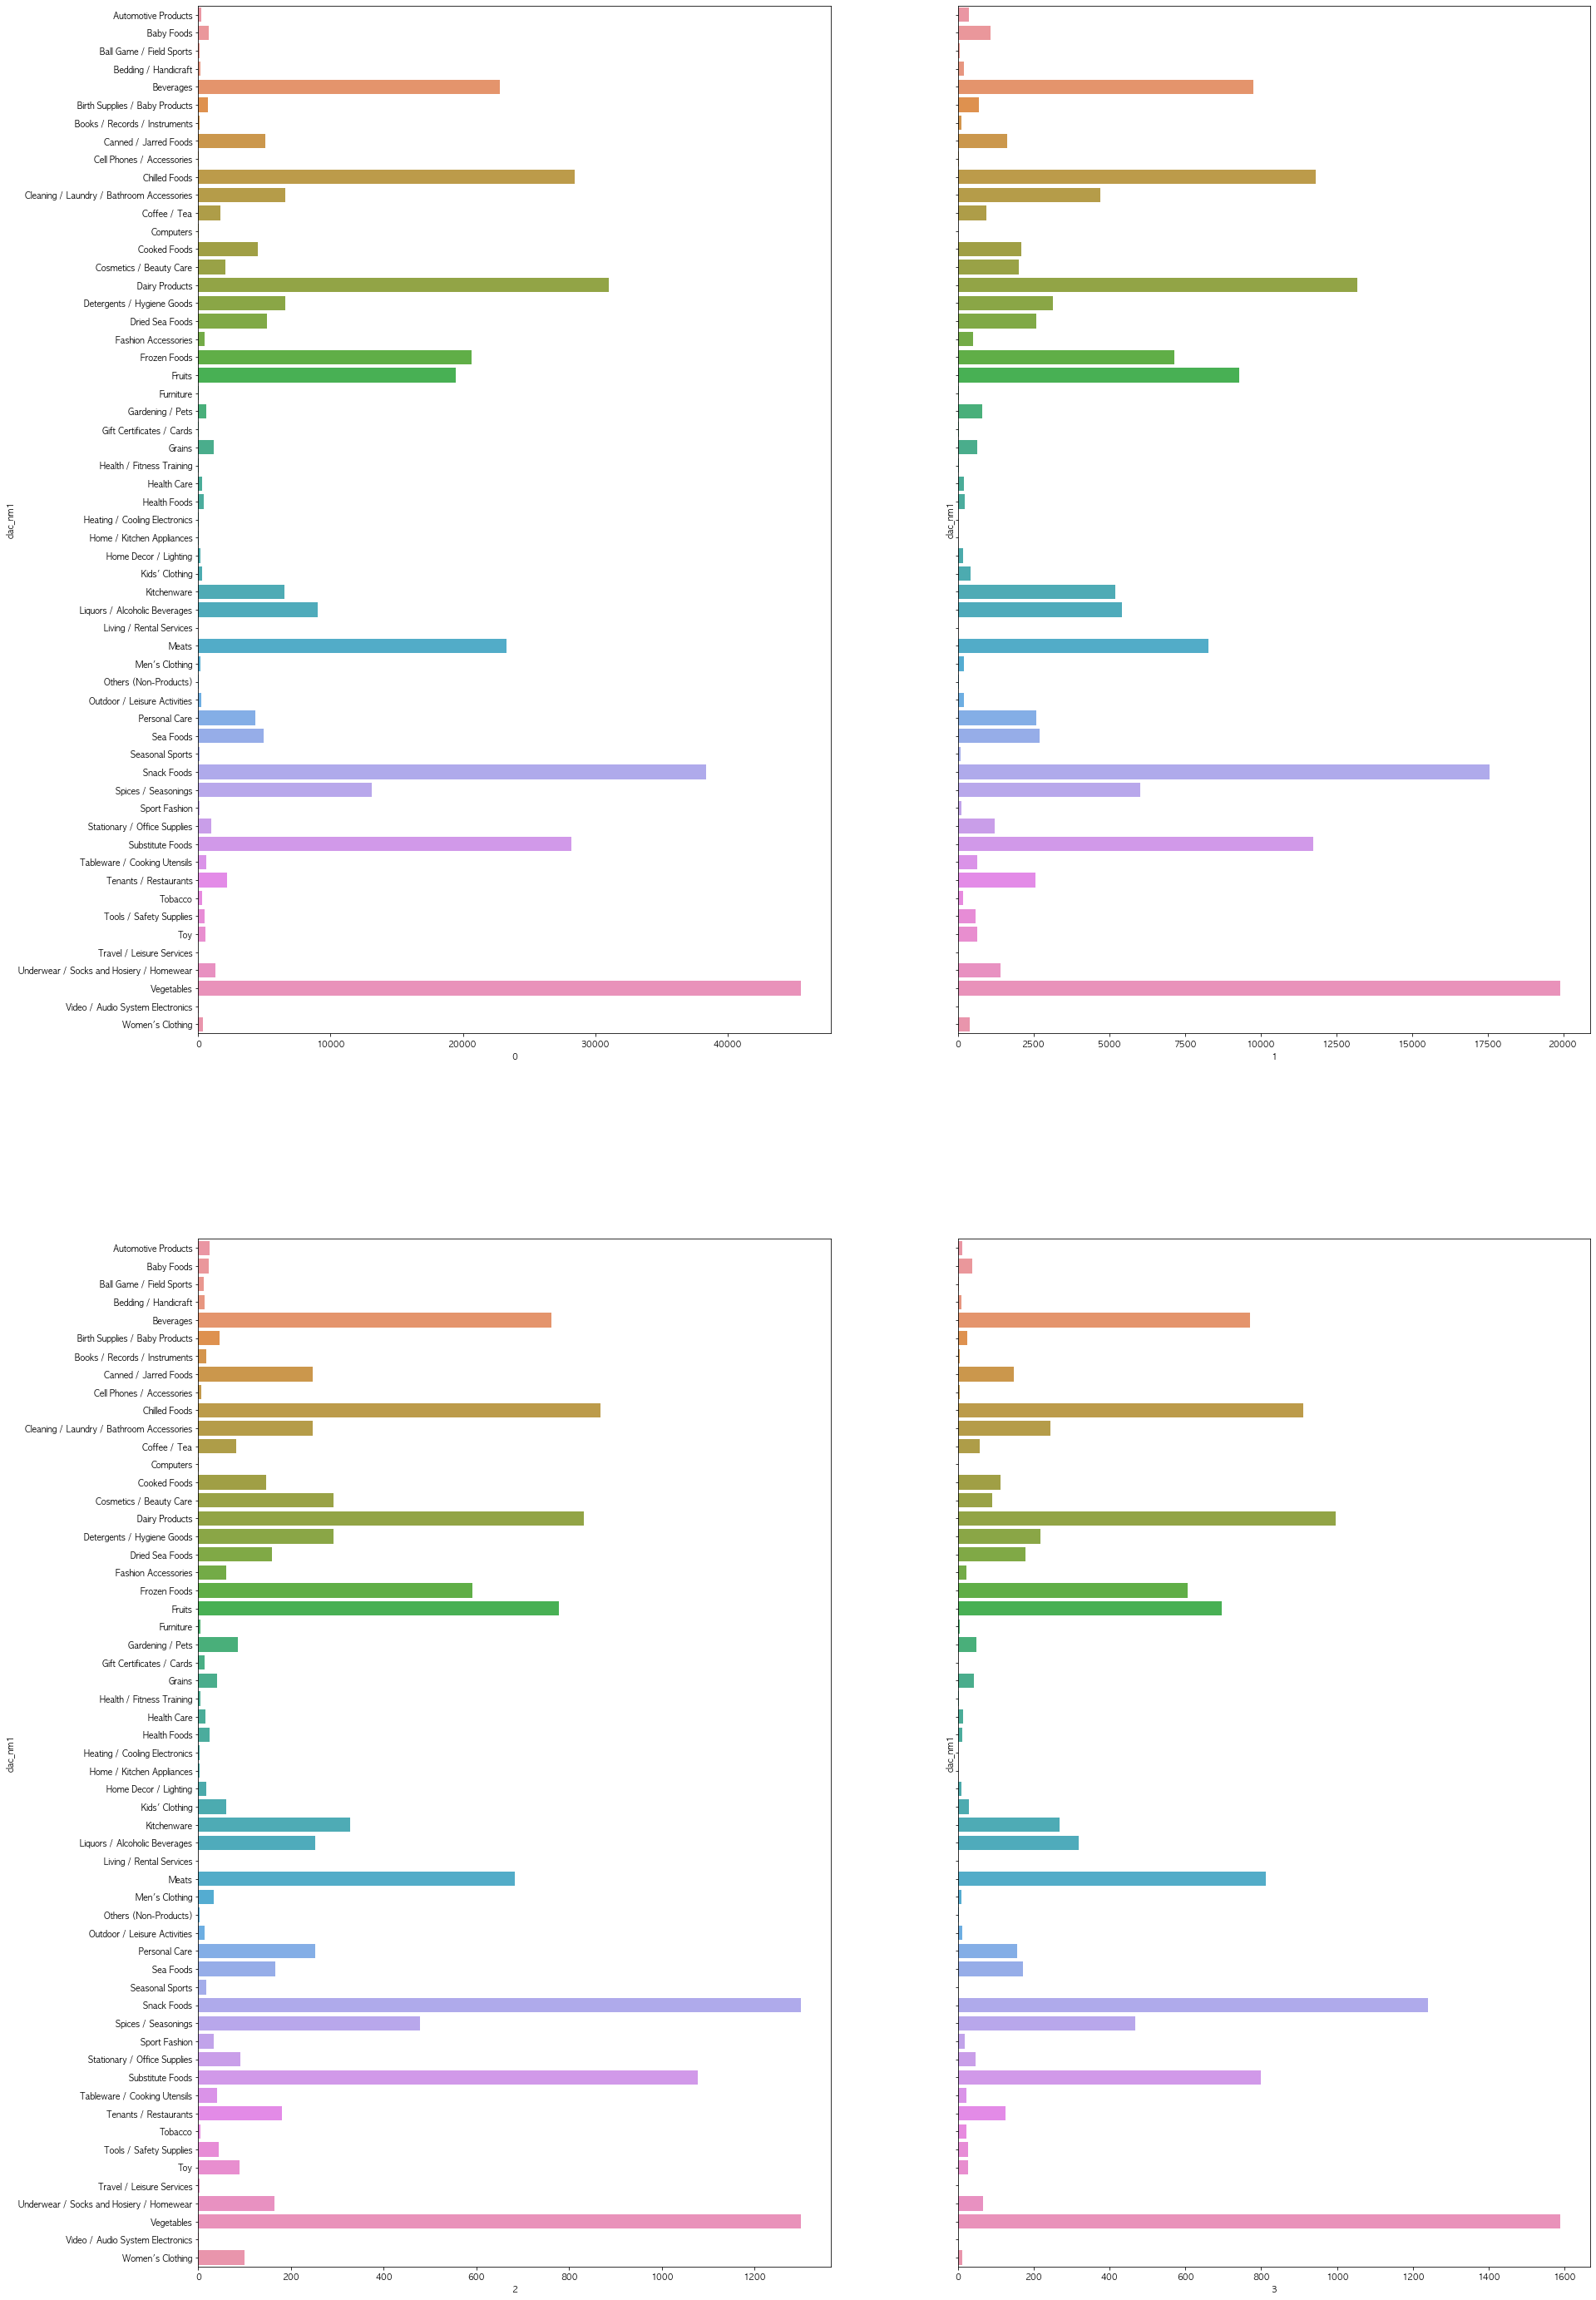

In [21]:
f, axes = plt.subplots(2, 2, figsize=(30, 50), sharey=True)
sns.barplot(data=a.reset_index(), y='clac_nm1', x=0, ax=axes[0,0])
ax[0].set_title('세그먼트 0')
sns.barplot(data=a.reset_index(), y='clac_nm1', x=1, ax=axes[0,1])
ax[1].set_title('세그먼트 1')
sns.barplot(data=a.reset_index(), y='clac_nm1', x=2, ax=axes[1,0])
ax[2].set_title('세그먼트 2')
sns.barplot(data=a.reset_index(), y='clac_nm1', x=3, ax=axes[1,1])
ax[3].set_title('세그먼트 3')
plt.show()

# 8. 고객 맞춤 상품 추천-협업필터링(Collaborative Filtering) <br/>

### 8.1. 입력데이터 구성 (Ratings Matrix 만들기)

In [46]:
final_ft.to_excel('final_ft.xlsx', index=False)
cs_seg = pd.read_excel('final_ft.xlsx')
cs_seg = cs_seg[['clnt_id','세그먼트']]
cs_tr = pd.read_csv('cs_tr.csv')
data = pd.merge(cs_tr,cs_seg, on = 'clnt_id')

In [47]:
data0 = data.query('세그먼트 == 0')
data1 = data.query('세그먼트 == 1')
data2 = data.query('세그먼트 == 2')
data3 = data.query('세그먼트 == 3')

In [48]:
# 행은 고객ID, 열은 상품명으로 pivoting 수행. 구매가 없는 값(NaN)은 모두 0으로 변환
ratings_matrix = pd.pivot_table(data0, index='clnt_id', columns='clac_nm3', values='pd_c', 
                                aggfunc=lambda x: 1 if len(x) >= 1 else 0, fill_value=0)

print(ratings_matrix.shape)
ratings_matrix

(4400, 1272)


clac_nm3,Accessory Bags,Accident Prevention Equipment,Adhesive Tapes,Adhesives,Adult's Bed Covers and Skirts,Adult's Diapers,Adult's Disposable Briefes,Adults' Bedding Sets,Adults' Blankets,Adults' Duvet / Duvet Cover,...,Yams,Yellow Corvina Fish,Yoga / Pilates Clothing,Yogurt Drinks,Young Pumpkins,Young Radishes,Yuzus / Quinces,Zipper Poly Bags / Plastic Bags,kelp,life Vests / Safety Accessories
clnt_id,,,,,,,,,,,,,,,,,,,,,
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
49,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72258,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
72267,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
72284,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 8.2. 유사집단 탐색
- 사용자 간 유사도 산출

In [49]:
# 유사도가 가장 높은 이웃의 수 설정 (분석가가 임의로 결정)
K = 30

In [50]:
# cosine_similarity()는 행을 기준으로(즉, 고객 간) 유사도를 계산
user_sim = cosine_similarity(ratings_matrix, ratings_matrix)

# cosine_similarity()로 반환된 numpy 행렬에 상품명을 매핑하기 위해 DataFrame으로 변환
# 행과 열이 동일한 데이터프레임이 생성됨.
user_sim = pd.DataFrame(user_sim, ratings_matrix.index, ratings_matrix.index)

# 다음 단계에서 사용하기 위해 의도적으로 대각선 값을 1에서 2(코사인 유사도 최대값 1보다 크게)로 변경
# np.fill_diagonal() 사용
np.fill_diagonal(user_sim.values, 2)

print(user_sim.shape)
user_sim

(4400, 4400)


clnt_id,2,9,24,38,49,106,124,202,218,275,...,72167,72193,72216,72228,72244,72258,72267,72284,72321,72424
clnt_id,,,,,,,,,,,,,,,,,,,,,
2,2.000000,0.074536,0.113228,0.048795,0.153093,0.145350,0.166667,0.086548,0.070014,0.123091,...,0.098295,0.063758,0.069007,0.080064,0.077152,0.085126,0.000000,0.191273,0.000000,0.121716
9,0.074536,2.000000,0.253185,0.261861,0.228218,0.260011,0.260875,0.309645,0.219179,0.302765,...,0.263752,0.199593,0.246885,0.214834,0.241523,0.266485,0.167542,0.228106,0.265684,0.163299
24,0.113228,0.253185,2.000000,0.099449,0.173344,0.131662,0.283069,0.264591,0.095130,0.167248,...,0.233723,0.129944,0.140642,0.108786,0.157243,0.115663,0.190885,0.173259,0.000000,0.124035
38,0.048795,0.261861,0.099449,2.000000,0.358569,0.283695,0.268373,0.342074,0.184482,0.252262,...,0.388499,0.167997,0.343452,0.210963,0.203289,0.249222,0.109682,0.223996,0.144943,0.160357
49,0.153093,0.228218,0.173344,0.358569,2.000000,0.370869,0.280671,0.357749,0.300123,0.263822,...,0.376206,0.234261,0.190160,0.220631,0.307096,0.338836,0.172062,0.253782,0.121268,0.260875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72258,0.085126,0.266485,0.115663,0.249222,0.338836,0.346446,0.127688,0.375742,0.143040,0.408651,...,0.301226,0.195387,0.281963,0.163572,0.078811,2.000000,0.143509,0.293080,0.202289,0.155417
72267,0.000000,0.167542,0.190885,0.109682,0.172062,0.136133,0.093659,0.170226,0.236067,0.069171,...,0.110474,0.107486,0.155113,0.134976,0.173422,0.143509,2.000000,0.035829,0.055641,0.102598
72284,0.191273,0.228106,0.173259,0.223996,0.253782,0.370688,0.191273,0.347642,0.107134,0.258985,...,0.300818,0.219512,0.369575,0.275654,0.147570,0.293080,0.035829,2.000000,0.189389,0.256091


In [51]:
# 각 고객마다 K-nearest neighbors 생성. 다음단계에서 사용하기 위해 의도적으로 자기 자신을 가장 가까운 이웃으로 설정(K+1개) 
# 행은 고객, 열은 K개의 이웃인 데이터 프레임이 만들어짐. 
knn = user_sim.apply(lambda x,k: x.sort_values(ascending=False).index[:k+1], args=(K,)).T
knn

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
clnt_id,,,,,,,,,,,,,,,,,,,,,
2,2,27375,13751,25221,46895,28523,10395,25801,5198,27056,...,22998,48205,54991,39641,30556,6403,56042,9417,43406,31443
9,9,37074,45251,22277,51819,64183,32944,28282,42605,59943,...,20748,36417,68575,21279,69316,51369,63693,26717,68916,14853
24,24,70174,67553,57210,15658,16590,19258,48240,41711,12458,...,30087,64883,35694,35265,27634,50253,67205,48820,38885,36068
38,38,31866,61870,68449,51369,42590,22910,39444,14882,13434,...,26597,66143,33696,23749,66425,59564,30156,62232,15979,28454
49,49,54847,51056,46192,67056,20367,14882,33696,50615,1496,...,31100,13849,23749,34181,62265,53402,25116,69414,60625,16272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72258,72258,51861,36417,51369,19923,34048,38056,72048,55780,40489,...,63693,56541,47330,49348,275,57179,22998,32923,13868,8591
72267,72267,21000,23143,65460,48636,7470,14215,16143,57179,44097,...,10553,3429,23088,33714,55094,70716,25169,46329,39240,32364
72284,72284,40737,14879,55270,15072,24195,5643,27056,52142,71310,...,68575,17236,66745,26567,20953,30242,55080,11615,49898,8412


## 8.3. 추천 상품 결정 (Top-N 상품추천)

In [52]:
# 추천할 상품수 설정 (분석가가 임의로 결정)
N = 10

In [53]:
# 추천 리스트에서 제외하기 위해 이미 구매한 상품 목록 작성
purchased_list = data.groupby('clnt_id')['clac_nm3'].unique()
purchased_list

clnt_id
2        [Ramens, Fried Tofu, Crab Sticks, Canned Veget...
9        [Young Pumpkins, Functional Milk, Fresh Milk, ...
20       [Korean Cabbages, Jumbo Spring Onions, Spinach...
23       [Chilled Tteokbokkis, Chilled Dressings, Chill...
24       [Functional Milk, Frozen Fried Foods, Frozen H...
                               ...                        
72342                            [Kids' Thermal Underwear]
72356    [Domestic Beefs - Rounds, Ciders, Domestic Por...
72373    [Chilled Refreshments, Functional Milk, Domest...
72410    [Sesame Leaves, Functional Milk, Crackers, Ban...
72424    [Chilled Noodles, Onions, Wrapping Vegetables,...
Name: clac_nm3, Length: 9290, dtype: object

In [54]:
# 이미 구매한 상품을 제외하고 유사집단에서 가장 많이 구매한 N개의 상품을 추천 
def top_n(x, n):
    # 고객이 구매했던 상품을 뽑아내는 과정: x[0]에는 고객id가 있음 (이를 위해 의도적으로 이웃의 수를 K+1로 했던 것)
    purchased = purchased_list.filter(items=[x[0]]).iloc[0]
    # 위 고객의 이웃들이 가장 많이 산 상품을 뽑아내는 과정: x[1:]에는 이웃들의 id가 들어가 있음. 
    candidate = ratings_matrix.filter(items=x[1:], axis=0).sum().sort_values(ascending=False).index.to_list()
    # 위 이웃들이 가장 많이 산 상품에서 이미 구매했던 상품을 제외하고 N개를 추천
    return [item for item in candidate if item not in purchased][:n]

# knn의 행, 즉 고객별로 top_n을 고객 수만큼 호출 
# 고객ID와 추천상품 두 개의 컬럼이 생기는데, 추천상품 컬럼에는 리스트 형태로 상품이 저장됨. 
recommend_list = knn.apply(top_n, args=(N,), axis=1).reset_index().rename(columns={0:'recommend_items'})
recommend_list

,clnt_id,recommend_items
0,2,"[Chicken Eggs, General Snacks, Fresh Milk, Spo..."
1,9,"[Chicken Eggs, Corn Snacks, Spoon Type Yogurts..."
2,24,"[Bibim Ramens, Fresh Milk, General Snacks, Coo..."
3,38,"[Tofu, Fish Cakes, Fresh Milk, Chilled Chicken..."
4,49,"[Frozen Dumplings, Frozen Fried Foods, Sausage..."
...,...,...
4395,72258,"[Corn Snacks, Ramens, Tofu, Sausages, Frozen F..."
4396,72267,"[Ramens, Spoon Type Yogurts, Bibim Ramens, Chi..."
4397,72284,"[Sausages, Functional Milk, Cone Ice Creams, T..."
4398,72321,"[Ramens, Chicken Eggs, Tofu, General Snacks, S..."


In [55]:
recommend_list.query('clnt_id == 38')['recommend_items'].tolist()

[['Tofu',
  'Fish Cakes',
  'Fresh Milk',
  'Chilled Chicken, Jokbal and Pork Feet',
  'Sausages',
  'Frozen Fried Foods',
  'Spoon Type Yogurts',
  'Fried Tofu',
  'Carrots',
  'Functional Milk']]

In [ ]:
recommend_list.query('clnt_id == 38')